## Определение испарения

*Выполнил:* гидрометеоролог Кирилл Жбаков

*Контакты:*

    - Telegram: @Zhbakov
    - Watsapp: +79035335522
    - Email: kirill.zhbakov@yandex.ru

**Цель** – определение значений испарения для города Дюртюли республики Башкартостан.

**Задачи:**

    - Загрузка данных об испарении;
    - Расчёт среднегодового испарения;
    - Расчёт среднемесячного испарения;
    - Расчёт испарения 1%, 3%, 50% обеспеченностей для месяцев тёплого периода (май-октябрь);    

In [1]:
# Импорт библиотек
import ee
import pandas as pd
import datetime
import scipy
import matplotlib.pyplot as plt
import numpy as np

### Данные

С целью расчёта значений испарения использовались данные Глобальной системы ассимиляции данных (GLDAS-2.2) Принстонского метеорологического центра. В настоящее время в GLDAS используются модели поверхности суши (LSM): Noah, CLSM, VIC.

Моделирование суточной модели водосбора GLDAS-2.2 началось 1 февраля 2003 года с использованием условий из моделирования суточной модели водосбора GLDAS-2.0. Это моделирование было выполнено с использованием полей метеорологического анализа из интегрированной системы прогнозирования Европейского центра среднесрочных прогнозов погоды (ECMWF)
(https://www.ecmwf.int/en/publications/ifs-documentation). Было обобщено общее наблюдение аномалий содержания воды в ходе эксперимента по восстановлению силы тяжести и климата (GRACE). Данные GRACE RL06 и последующих наблюдений GRACE были
предоставлены Центром космических исследований Техасского университета. При моделировании ежедневной модели водосбора используется схема растительного покрова UMD из карты растительного покрова AVHRR. Информационные продукты GLDAS-2.2.

Основные характеристики GLDAS.
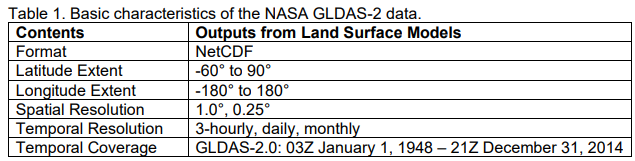
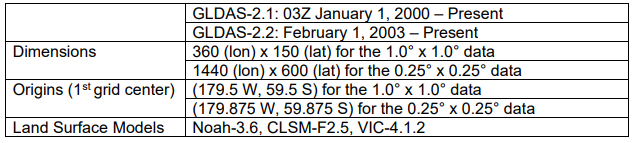

С целью расчета испарения использовался характеристика модели "Evap_tavg" с еденицей измерения кг/м^2/с.

### Методика

Данные об испарении загружались в точке с координатами 55.485290 с.ш. 54.873472 в.д. за период с 01.01.2003 до 31.12.2022 с помощью Google Earth Engine и языка программирования python. Расчёт выполнялся с помощью библиотеки pandas. Обеспеченные значения рассчитывались с помощью библиотеки scipy с использованием аналитической кривой распределения Пирсона третьего типа.

In [2]:
# Инициализация Google Earth Engine
ee.Initialize()

In [3]:
# Создание области интереса (Region of Interest - ROI)
point = ee.Geometry.Point(54.873472, 55.485290)  

# Задание временного диапазона
start_date = '2003-01-01'
end_date = '2022-12-31'

# Загрузка коллекции изображений
collection = ee.ImageCollection('NASA/GLDAS/V022/CLSM/G025/DA1D') \
    .filterDate(start_date, end_date)

# Получение данных в точке интереса
series = (collection.select('Evap_tavg') 
    .filterBounds(point)
    .getRegion(point, scale=1))  # scale - масштаб

# Преобразование результата в список Python
ee_list = series.getInfo()

In [4]:
# Создаем DataFrame из данных и заголовков
header = ee_list[0]
data = ee_list[1:]
df = pd.DataFrame(data, columns=header)

In [5]:
# Преобразование в формат datetime
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

In [6]:
# Группировка по году и месяцу
df_grouped = df.groupby(['month', 'year']).agg(
    Evap=('Evap_tavg', 'mean'),  # Вычисление суммы 'Evap_tavg'
    Count=('Evap_tavg', 'count')  # Подсчет количества значений
).reset_index()

In [7]:
# Превод значений из kg/m^2/s в mm
df_grouped['Evap_mm'] = df_grouped['Evap'] * df_grouped['Count'] * 86400

In [8]:
# Расчёт среднемесячного значения
df_grouped.groupby('month')['Evap_mm'].mean()

month
1       0.381149
2       1.989011
3       9.941147
4      36.265188
5      86.992530
6     106.478716
7     105.398936
8      77.050383
9      34.744077
10     13.517487
11      3.732788
12      0.517387
Name: Evap_mm, dtype: float64

In [9]:
# Расчёт среднегодового значения
df_grouped.groupby('year')['Evap_mm'].sum().mean()

476.9897412440715

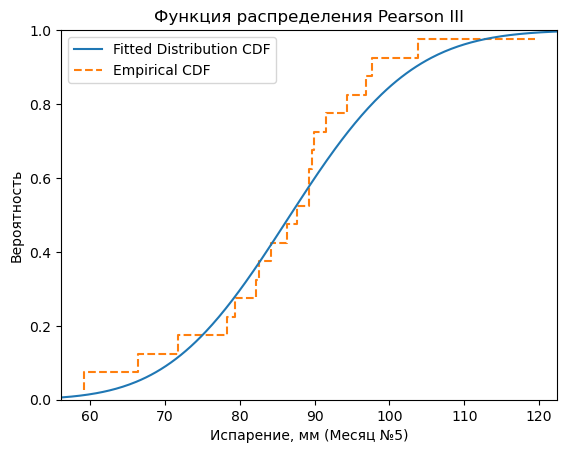

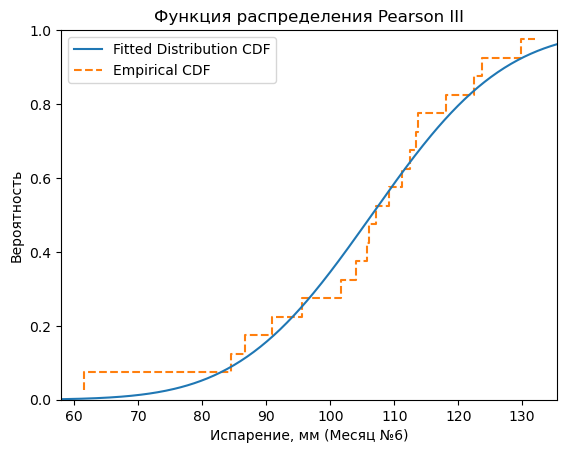

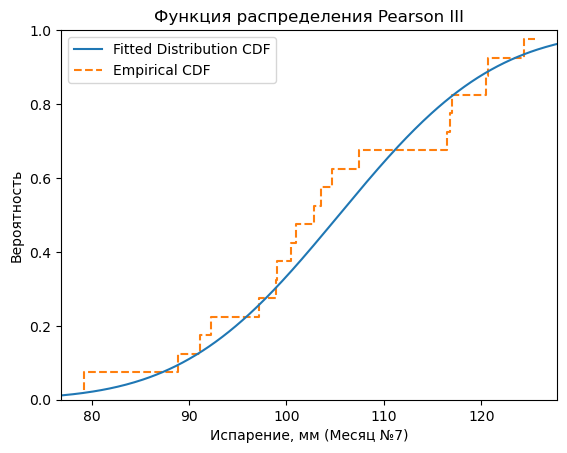

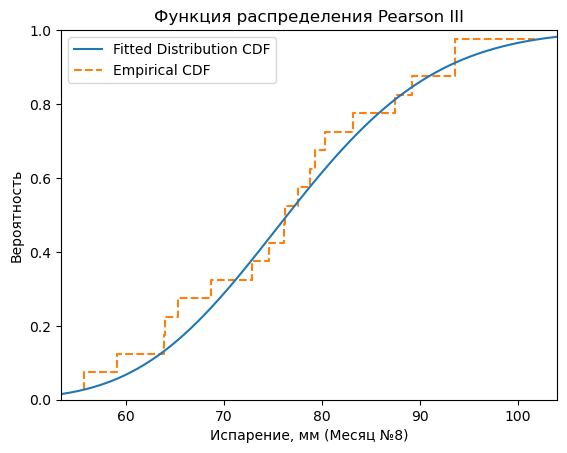

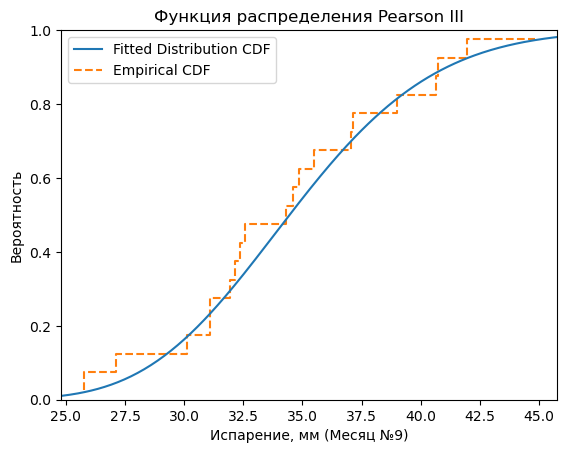

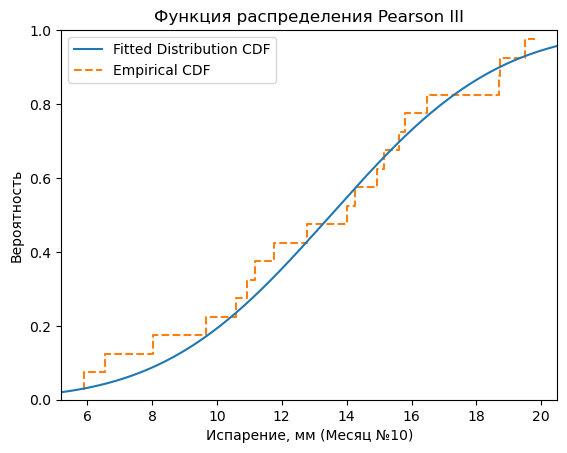

In [10]:
# Подсчёт обеспеченных значений
ppf_values_1 = []
ppf_values_3 = []
ppf_values_50 = []
months = [5, 6, 7, 8, 9, 10]

for month in months:
    df = df_grouped[df_grouped['month'] == month]
    dist = scipy.stats.pearson3
    bounds=[(0,1000),(0,1000), (0,1000)]
    res = scipy.stats.fit(dist, df['Evap_mm'].array, bounds=bounds)
    a, b, c = res.params
    fitted_dist = scipy.stats.pearson3(a, b, c)
    ppf_values_1.append(fitted_dist.ppf(0.99))
    ppf_values_3.append(fitted_dist.ppf(0.97))
    ppf_values_50.append(fitted_dist.ppf(0.50))
    
    res.plot(plot_type='cdf')
    plt.title('Функция распределения Pearson III')
    plt.ylabel('Вероятность')
    plt.xlabel('Испарение, мм (Месяц №{})'.format(month));
    plt.show()

In [11]:
Evap = pd.DataFrame({"Month" : months,
                     "Values_1p" : ppf_values_1,
                     "Values_3p" : ppf_values_3,
                     "Values_50p" : ppf_values_50})  
Evap

,Month,Values_1p,Values_3p,Values_50p
0,5,117.621931,111.531981,86.778324
1,6,144.462008,137.187252,106.478730
2,7,134.627784,129.029723,105.398936
3,8,107.304300,100.896426,76.477113
4,9,47.275479,44.564057,34.455428
5,10,22.956197,21.148444,13.517479


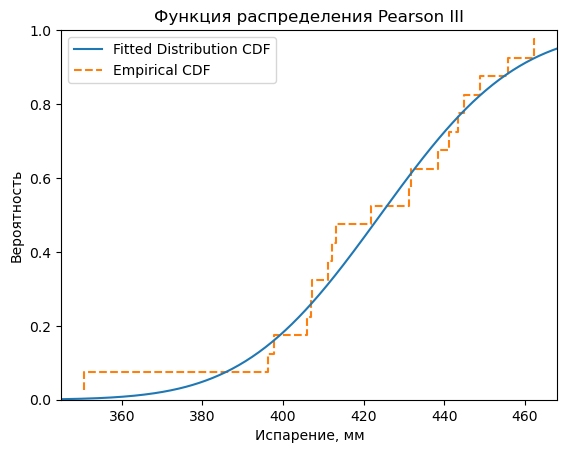

In [12]:
# Тёплый период
df_grouped_warm = df_grouped[df_grouped['month'].isin(months)]
df_grouped_warm = df_grouped_warm.groupby('year')['Evap_mm'].sum().reset_index()

ppf_pct = [0.99, 0.97, 0.50]
ppf_values = []
for pct in ppf_pct:
    dist = scipy.stats.pearson3
    bounds=[(0,1000),(0,1000), (0,1000)]
    res = scipy.stats.fit(dist, df_grouped_warm['Evap_mm'].array, bounds=bounds)
    a, b, c = res.params
    fitted_dist = scipy.stats.pearson3(a, b, c)
    ppf_values.append(fitted_dist.ppf(pct))
    
res.plot(plot_type='cdf')
plt.title('Функция распределения Pearson III')
plt.ylabel('Вероятность')
plt.xlabel('Испарение, мм')
plt.show();

In [13]:
Evap = pd.DataFrame({"Pct" : ppf_pct,
                     "Evap_mm" : ppf_values})  
Evap

,Pct,Evap_mm
0,0.99,486.122900
1,0.97,474.259718
2,0.50,424.182139


### Резултаты

- Рассчитаны среденгодовые и среднемесячные значения испарения.
- Рассчитаны обеспеченные среднемесячные значения и за тёплый период. 